In [1]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from adjustText import adjust_text
import plotly.express as px
import sqlite3 as sql
import warnings
warnings.filterwarnings("ignore")

## Retreive Data from Database

In [2]:
# path to current SQLite  db
path = "data.sqlite"

# establish connection
conn = sql.connect(path)
cur = conn.cursor()

# read relevant (see below) columns from the dna table into a new database.
# close connection

db = pd.read_sql_query(
    "SELECT accession_number, name, category, mt_dna, length FROM MtDNA",
    conn
)

conn.close()

db

,accession_number,name,category,mt_dna,length
0,NC_011137,European Neanderthal,Human,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,16565
1,KC345764,South African Human,Human,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,16567
2,FN673705,Altai Denisovan,Human,GATCACAGGTCTATCACCCTATTAACCACTCACGGGAGCTCTCCAT...,16570
3,NC_002083,Sumatran Orangutan,Orangutan,GTTTATGTAGCTTATTCTATCCAAAGCAATGCACTGAAAATGTCTC...,16499
4,NC_001646,Bornean Orangutan,Orangutan,GTTTATGTAGCTTATTCCATCCAAAGCAATACACTGAAAATGTCTC...,16389
5,NC_011120,Western Lowland Gorilla,Gorilla,GTTTATGTAGCTTACCTCCCCAAAGCAATACACTGAAAATGTTTCG...,16412
6,KM242275,Eastern Lowland Gorilla,Gorilla,GTTTATGTAGCTTACCTCCCCAAAGCAATACACTGAAAATGTTTCG...,16416
7,NC_001644,Bonobo,Chimp,GTTTATGTAGCTTACCCCCTTAAAGCAATACACTGAAAATGTTTCG...,16563
8,JF727201,Chimp Schweinfurthii,Chimp,GTTTATGTAGCTTACCCCCTCAAAGCAATACACTGAAAATGTTTCG...,16560
9,KM679417,Chimp Ellioti,Chimp,GTTTATGTAGCTTACCCCCTCAAAGCAATACACTGAAAATGTTTCG...,16559


## Building Feature Matrix based on given k

In [3]:
def build_feet_matrix(db, k = 3):
    """
    input: mtdna db (pandas.DataFrame), k (int, default =3)

    contruct kmer frequency matrix from the mtdna sequences

    returns numpy.ndarray, a matrix such that each row is the kmer frequency
    vector for some sequence.
    """

    # initialize vectors, convert each sequence into its kmer vector
    vectors = []
    for seq in db["mt_dna"]:
        vec = get_kmers(seq, k)
        vectors.append(vec)

    # stack the vectors to create the desired matrix
    x = np.vstack(vectors)
    return x

def get_kmers(sequence, k = 3):
    """
    input: a sequence (str), desired k (int)

    computes kmer frequency counts for a single mtdna sequence

    returns numpy.ndarray of kmer counts
    """

    # generate all possible kmers of given length k from alphabet ACGT
    kmers = [''.join(p) for p in product("ACGT", repeat = k)]
    counts = {kmer: 0 for kmer in kmers}

    # initialize count to 0, "slide" accross the entire sequence and count kmers
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i: i + k]
        if kmer in counts:
            counts[kmer] += 1

    # return the counts in kmer order
    return np.array([counts[k] for k in kmers])

## 2D PCA

In [4]:
def plot_2D_PCA_by_category(X, db, title="PCA Plot by Category"):
    """
    input: feature matrix X (numpy.ndarray), db (pandas.DataFrame)
    plot title: (str))

    Perform PCA on the feature matrix X. Plots PC1 and PC2. Only labels points,
    and colored by TRUE category.

    returns: none, displays plot
    """

    # compute PCA
    pca = PCA(n_components=2)
    pcs = pca.fit_transform(X)

    db["PC1"] = pcs[:,0]
    db["PC2"] = pcs[:,1]

    plt.figure(figsize=(10,8))

    # Get unique categories, assign colors
    unique_categories = db["category"].unique()
    colors = plt.cm.get_cmap("tab10", len(unique_categories))

    for i, category in enumerate(unique_categories):
        category_db = db[db["category"] == category]
        plt.scatter(category_db["PC1"], category_db["PC2"],
                    color=colors(i), label=category)

    texts = []
    for i, row in db.iterrows():
        texts.append(plt.text(row["PC1"], row["PC2"], row["name"], fontsize=8))
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='gray', lw=0.5))

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend(title="True Category")
    plt.show()


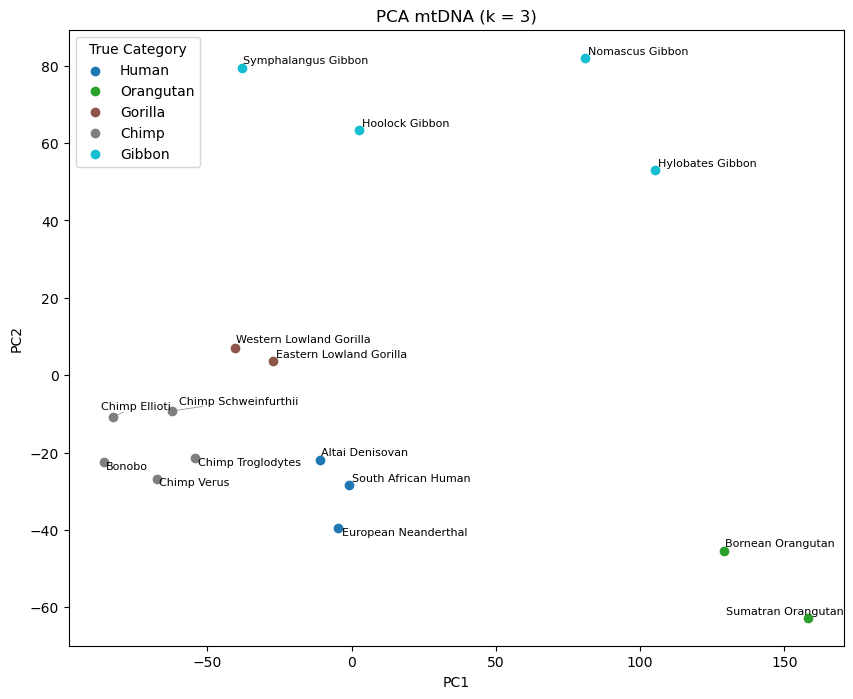

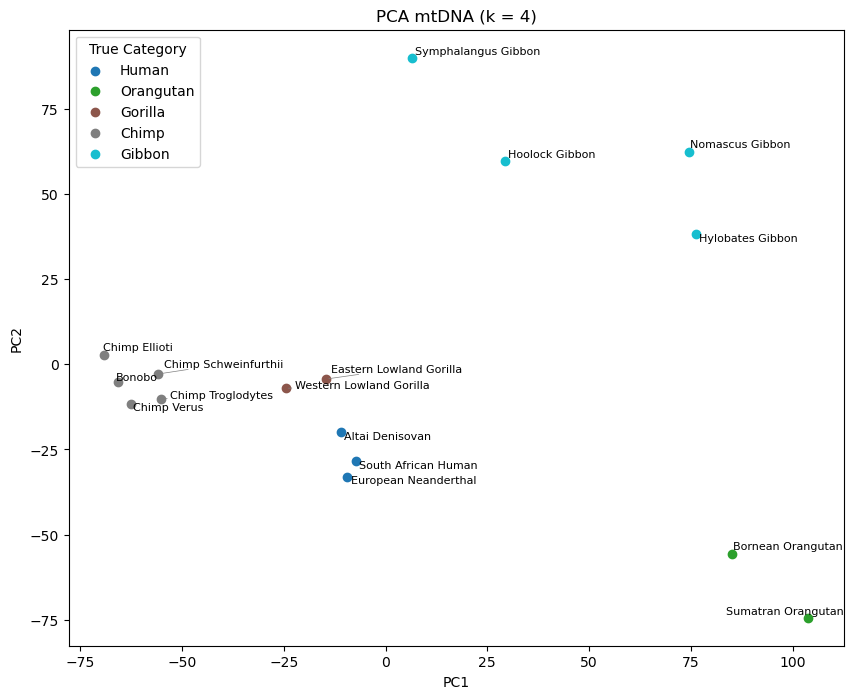

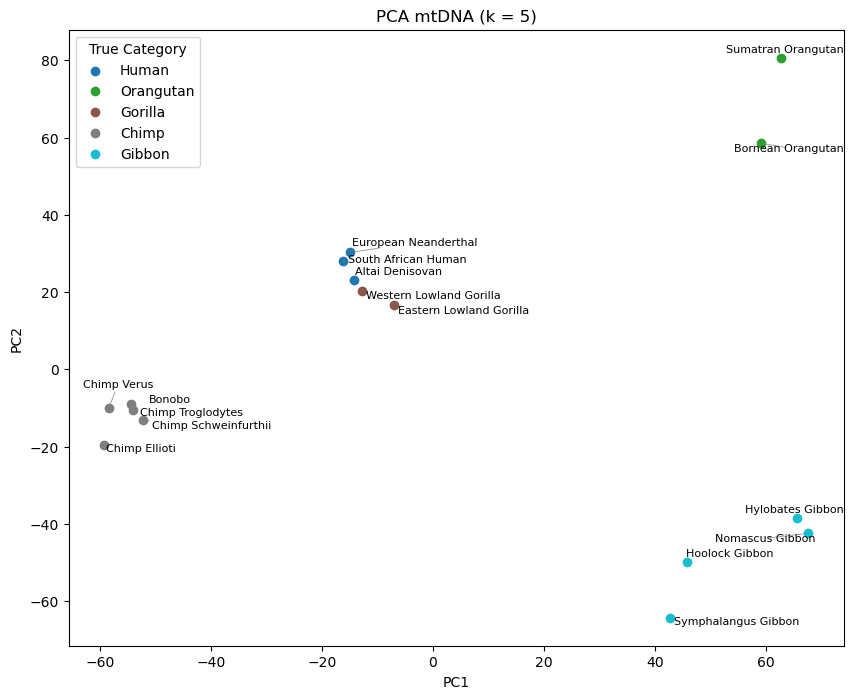

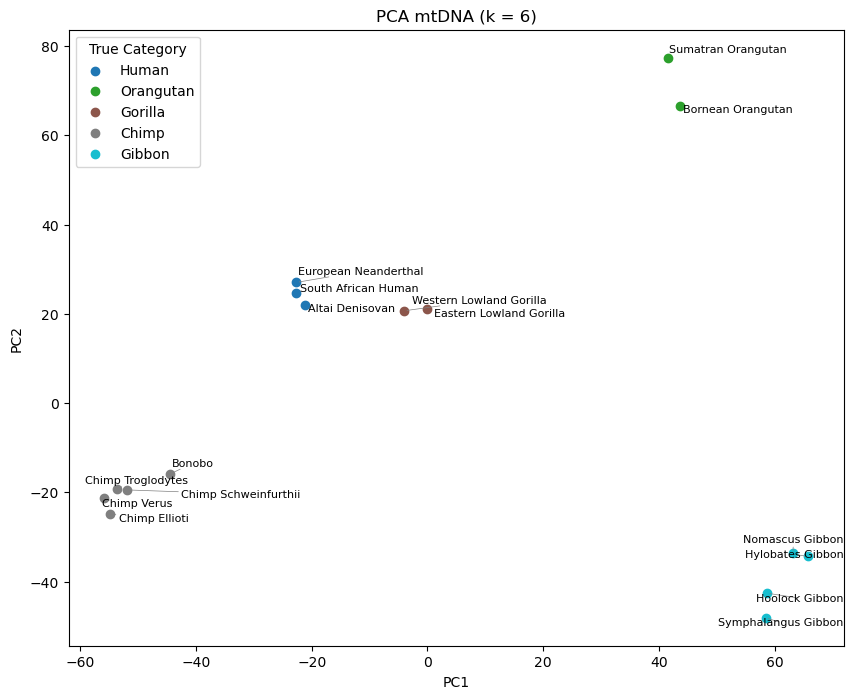

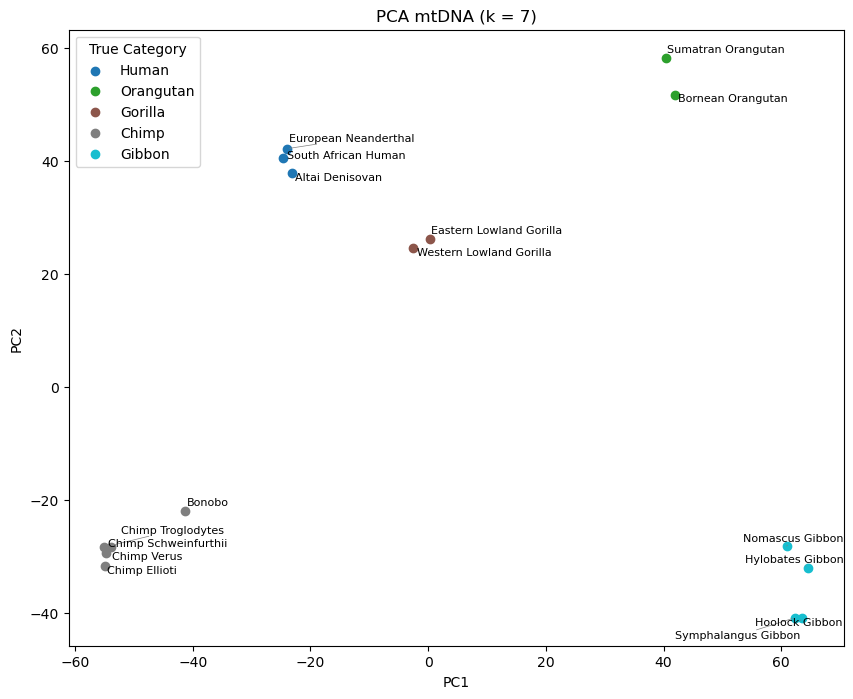

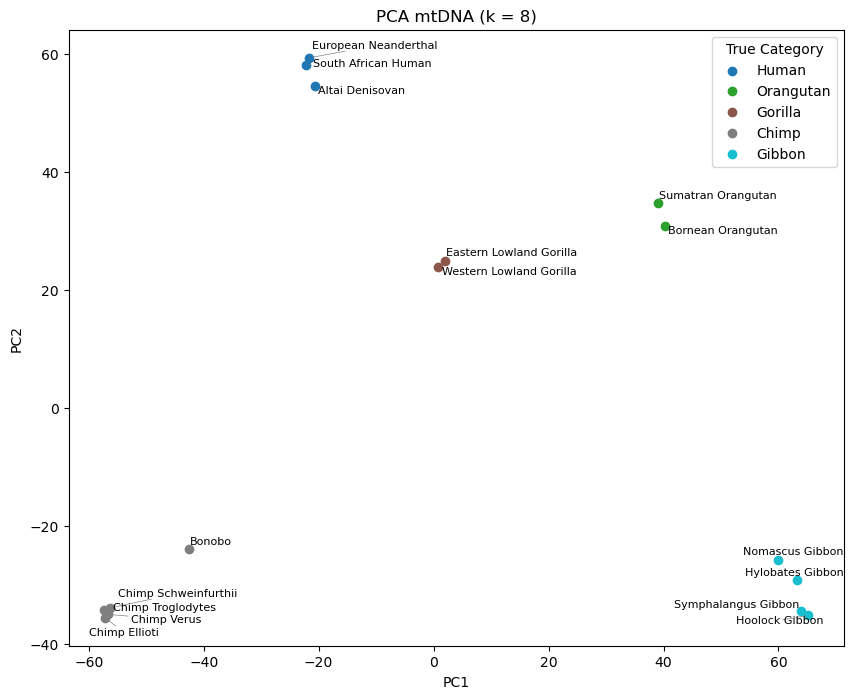

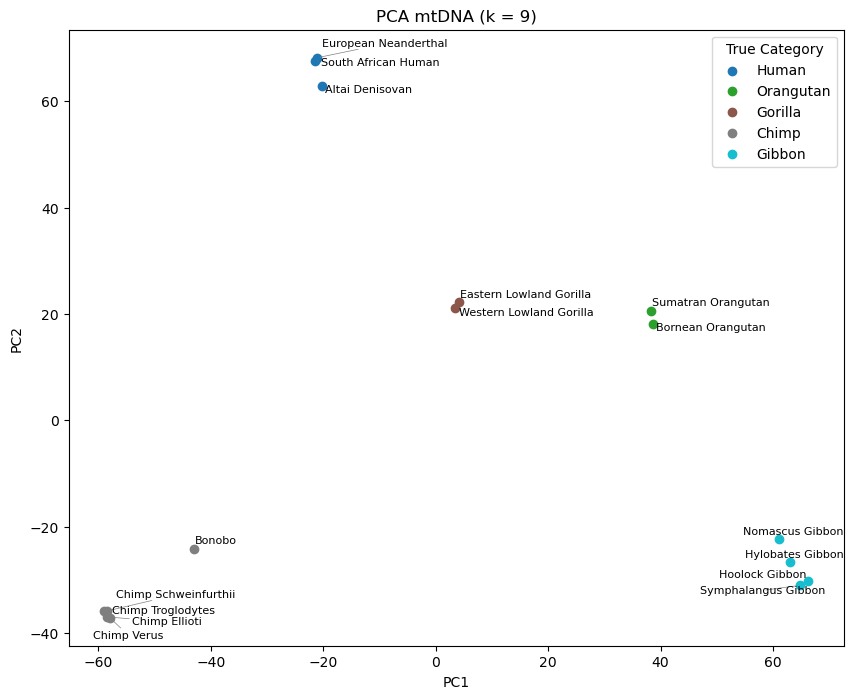

In [5]:

Xs = {}

for k in range(3, 10):
    Xs[k] = build_feet_matrix(db, k=k)

for k, X in Xs.items():
    plot_2D_PCA_by_category(X, db,
            title=f"PCA mtDNA (k = {k})")

## 3D PCA

In [9]:
def plot_3D_PCA_by_category(X, db, title, filename):
    """
    input: feature matrix X (numpy.ndarray), db (pandas.DataFrame)
    plot title: (str))

    Perform PCA on the feature matrix X (Now with 3 components). Plots PC1 and
    PC2 and PC3 via plotly. Points are colored by true category rather than
    cluster

    returns: none, displays an interactable plot.
    """
    # Run PCA with 3 components
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)

    # work on db copy
    db = db.copy()
    db["PC1"] = pcs[:, 0]
    db["PC2"] = pcs[:, 1]
    db["PC3"] = pcs[:, 2]

    # create 3D scatter plot with true category colors
    fig = px.scatter_3d(
        db,
        x="PC1",
        y="PC2",
        z="PC3",
        color="category",
        symbol="category",
        hover_name="name",
        hover_data={"category": True},
        title=title
    )

    # labeling axes and legend
    fig.update_layout(
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3"
        ),
        legend_title="Category",
        margin=dict(l=0, r=0, b=0, t=50)
    )
    
    
    # save to HTML
    fig.write_html(filename)
    
    # plot
    fig.show()


In [10]:

X9 = build_feet_matrix(db, 9)
plot_3D_PCA_by_category(X9, db, title="PCA mtDNA (k=9)", filename="pca_k9_plot.html")
